# **This project is done on Google Colab**
### **Note :- To run this project on platform other than colab change the directories locations in this project**

# **1. Load the data from Github**

In [ ]:
!git clone -l -s git://github.com/darkshadow013/Land-cover-ML himanshu-garg
%cd himanshu-garg
!ls

Cloning into 'himanshu-garg'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 52 (delta 9), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (52/52), 22.01 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/himanshu-garg
'Akshay poriya'			  IP_CNN_SVM_BEST.sav
 Data				  IP_SVM_BEST.sav
 INDIAN_PINES_CNN_TRY		  parameters.py
 INDIAN_PINES_SVM_TRY		  project_assessment_report.docx
 IP_CNN_samples3200_epoch200.h5   README.md
 IP_CNN_SVM			 'Report land cover - Copy.docx'


# **2. Data Pre-processing**

In [ ]:
# Import the necessary libraries
!pip install spectral
from spectral import *
import scipy
import scipy.io as sio
import scipy.ndimage
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from skimage.transform import rotate
#from spectral import *
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils
import itertools
import os
import random
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import parameters as p
import pickle

     |████████████████████████████████| 184kB 5.7MB/s 
  Created wheel for spectral: filename=spectral-0.22.2-cp37-none-any.whl size=212938 sha256=86b0004378a46debce44d61c27bcee553e36155a764cd9795ea737508244e2af
  Stored in directory: /root/.cache/pip/wheels/fb/00/da/ac778d1ab6e196cb7f56d104d4dfdfc0aad4e2b208275c0726
Successfully built spectral


In [ ]:
#Files_CNN is used to store the reports of this project
if not os.path.exists('/content/Files_CNN'):
    os.makedirs('/content/Files_CNN')

In [ ]:
mat_x = sio.loadmat('/content/himanshu-garg/Data/Indian_pines_corrected.mat')['indian_pines_corrected']        # shape 145*145*220
mat_y = sio.loadmat('/content/himanshu-garg/Data/Indian_pines_gt.mat')['indian_pines_gt']                      # shape 145*145

In [ ]:
h, w, b = p.h, p.w, p.b           # height,width and band of image
patch_size = p.patch_size                        # patch size (window size)
oversampling = p.oversampling               # Turn true to make distribution of samples across various classes to be uniform
no_of_patch = p.no_of_patch                # if oversampling is true enter no of patches for each class

target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
           ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
            'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
           'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
           'Stone-Steel-Towers']

In [ ]:
x_np, y_np = np.array(mat_x), np.array(mat_y)
x, y = x_np.reshape(h,w,b), y_np.reshape(h,w)       # x and y are equal to x_np and y_np

In [ ]:
def normalize_x(x):
    x = x.astype(float)
    for i in range(b):
      x[:,:,i] = x[:,:,i]/np.max(x[:,:,i])
    return x

In [ ]:
def create_padded_x(x,patch_size):
    pad_width = int( (patch_size-1)/2 )
    padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')
    return padded_x

In [ ]:
x=normalize_x(x)

In [ ]:
padded_x=create_padded_x(x,patch_size)

In [ ]:
def ground_truth_patches_labels(h,w,padded_x,patch_size):
    X,Y = [],[]
    for i in range(h):
      for j in range(w):
        if(y[i][j]!= 0):
          patch = padded_x[i:i+patch_size,j:j+patch_size,:]
          X.append(patch)
          Y.append(y[i][j]-1)
    return X,Y

In [ ]:
X,Y=ground_truth_patches_labels(h,w,padded_x,patch_size)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split( X,Y, test_size=0.25,stratify=Y, random_state=10)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([  35, 1071,  622,  178,  362,  547,   21,  358,   15,  729, 1841,
        445,  154,  949,  289,   70]))


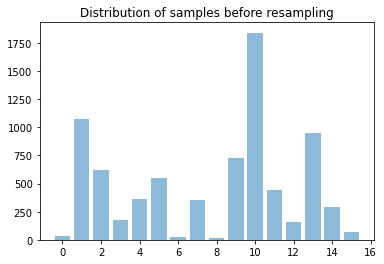

In [ ]:
u_c = np.unique(y_train,return_counts=True)
print(u_c)
plt.bar( u_c[0],u_c[1], align='center', alpha=0.5)
plt.title('Distribution of samples before resampling')
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
       200, 200, 200]))


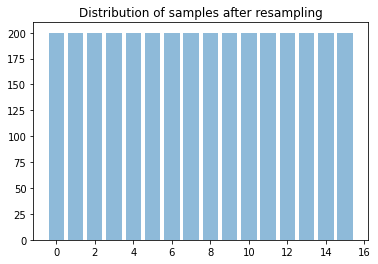

In [ ]:
output_classes = len(np.unique(y_np))-1
classes = []
if(oversampling):
    for i in range(output_classes):
        classes.append([])
        
    for i in range(len(y_train)):
        classes[y_train[i]].append(x_train[i])
        
    for c in range(output_classes):
        temp = classes[c]
        for i in range( int( no_of_patch / len(classes[c]) ) ):
            classes[c]+=temp
        shuffle(classes[c])
        classes[c] = classes[c][0:no_of_patch]
        
    x_train,y_train = [],[]
    for c in range(output_classes):
        x_train.extend( classes[c] )
        for i in range(len(classes[c])):
            y_train.append(c)
            
    randomize = np.arange(len(x_train))
    np.random.shuffle(randomize)
    x_train = [x_train[i] for i in randomize]
    y_train = [y_train[i] for i in randomize]
    
    u_c = np.unique(y_train,return_counts=True)
    print(u_c)
    plt.bar( u_c[0],u_c[1], align='center', alpha=0.5)
    plt.title('Distribution of samples after resampling')
    plt.show()

In [ ]:
x_train,x_test,y_train,y_test= np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)

# **3. Build and train CNN model on DATASET**

In [ ]:
CONV_1_CHANNELS = p.CONV_1_CHANNELS
CONV_2_CHANNELS = p.CONV_2_CHANNELS
FC_1_UNITS = 200
FC_2_UNITS = 84
FC_3_UNITS = 16

#Kernel Sizes
CONV_K_S = 5
POOL_K_S = 2

STRIDES = 2
# Before x_train.shape= {number,height,width,bands}
# Aftet x_train.shape= {number,bands,height,width}
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[3], 
                               x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[3], 
                             x_test.shape[1], x_test.shape[2]))
p1=y_train
q1=y_test
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
a1=x_test
b1=y_test

In [ ]:
input_shape= x_train[0].shape

In [ ]:
# Define the model structure
model = Sequential()
model.add(Conv2D(500, (3,3) , activation='relu', input_shape=input_shape, strides = STRIDES, padding = 'same'))
model.add(MaxPooling2D(pool_size = POOL_K_S, padding = 'same', strides = STRIDES))
model.add(Conv2D(100, (3,3) , activation='relu',strides = STRIDES, padding = 'same'))
model.add(MaxPooling2D(pool_size = POOL_K_S, padding = 'same', strides = STRIDES))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(16,activation='softmax'))

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, 
                              min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="checkpoint.hdf5", verbose=1, 
                              save_best_only=True)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
                              metrics=['accuracy'])

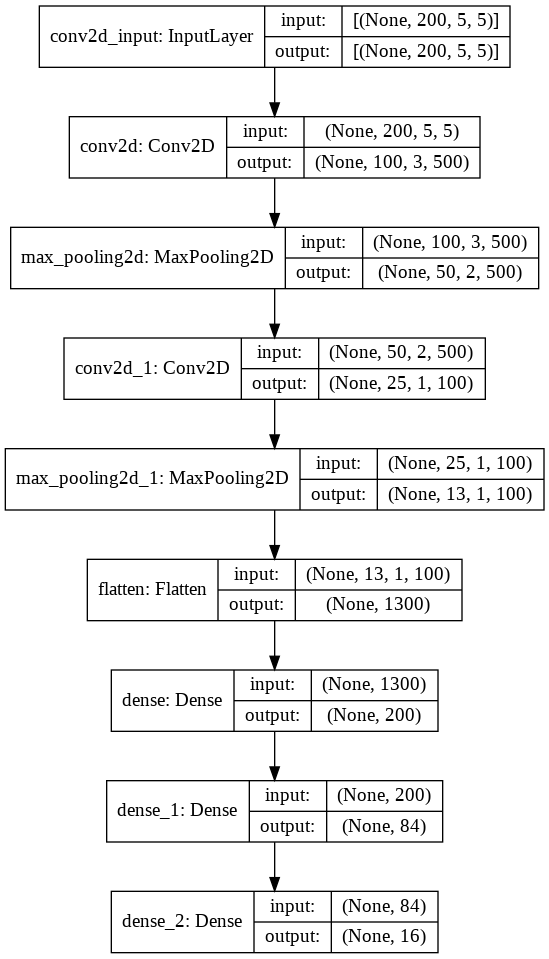

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='/content/Files_CNN/CNN_model.png', show_shapes=True)

In [ ]:
if(os.path.exists('/content/himanshu-garg/IP_CNN_samples3200_epoch200.h5')):
    # load the model architecture and weights
    model.load_weights("/content/himanshu-garg/IP_CNN_samples3200_epoch200.h5")
else:
    # Start to train model 
    history = model.fit(x_train, y_train, 
                        batch_size=32, 
                        epochs=200, 
                        verbose=1, 
                        validation_data=(x_test, y_test),
                        callbacks=[reduce_lr, checkpointer],
                        shuffle=True)
    # save the model with h5py
    import h5py
    model.save('/content/himanshu-garg/IP_CNN_samples3200_epoch200.h5')

for l in range(len(model.layers)):
    print(l, model.layers[l])

0 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f408326c8d0>
1 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4083329b90>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f408327d950>
3 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f407d271d50>
4 <tensorflow.python.keras.layers.core.Flatten object at 0x7f4083329750>
5 <tensorflow.python.keras.layers.core.Dense object at 0x7f407d27ab90>
6 <tensorflow.python.keras.layers.core.Dense object at 0x7f407d27ff90>
7 <tensorflow.python.keras.layers.core.Dense object at 0x7f407d290c50>


# **4. Feature Extraction from second last layer of CNN**

In [ ]:
model.layers[0].input

<KerasTensor: shape=(None, 200, 5, 5) dtype=float32 (created by layer 'conv2d_input')>

In [29]:
# feature extraction layer
getFeature = K.function([model.layers[0].input],
                        [model.layers[6].output])
# classification layer
#getPrediction = K.function([model.layers[7].input],
#                           [model.layers[7].output])

In [31]:
exTrain3000 = getFeature([x_train])[0]
exTest1000 = getFeature([x_test])[0]

In [32]:
y_train=p1
y_test=q1
y_train3000 = y_train
y_test1000 = y_test

In [33]:
print(exTrain3000.shape, exTest1000.shape, y_train3000.shape, y_test1000.shape)

(3200, 84) (2563, 84) (3200,) (2563,)


# **5. Build and Train SVM based on Features from CNN**

In [34]:
if(os.path.exists('/content/himanshu-garg/IP_CNN_SVM_BEST.sav')):
    # load the model 
    filename = '/content/himanshu-garg/IP_CNN_SVM_BEST.sav'
    svmclf = pickle.load(open(filename, 'rb'))
else:
    C = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    sigma = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    gamma=[]
    for i in range(0,len(sigma)):
        gamma.append((1/(2 * sigma[i]**2)))
    """parameters = {'kernel':['rbf'], 
                  'C':C,
                  'gamma':gamma}"""
    parameters = {'kernel':['rbf'], 
                  'C':[30],
                  'gamma':[0.005]}
    clf = GridSearchCV(SVC(), parameters)
    clf.fit(exTrain3000, y_train3000)
    #By this we obtain optimal C=30, gamma=0.005

    svmclf = clf.best_estimator_
    svmclf.fit(exTrain3000, y_train3000)

    filename = '/content/himanshu-garg/IP_CNN_SVM_BEST.sav'
    pickle.dump(svmclf, open(filename, 'wb'))

# **6. Save the reports**

In [35]:
def save_report_of_CNN_on_test_samples(y_test,test_accuracy):
    file_name = "/content/Files_CNN/Report_cnn_on_TEST_SAMPLES.txt"
    with open(file_name, 'w') as x_file:
        x_file.write('Number of Test Samples : {} '.format(y_test.shape[0]))
        x_file.write('\n')
        x_file.write('Test accuracy : {} (%)'.format(test_accuracy))

In [36]:
def save_report_of_CNN_SVM_on_train_samples(y_train3000,train_accuracy,classification,confusion):
    file_name = "/content/Files_CNN/Report_cnn_svm_on_TRAIN_SAMPLES.txt"
    with open(file_name, 'w') as x_file:
        x_file.write('Number of train Samples : {} '.format(y_train3000.shape[0]))
        x_file.write('\n')
        x_file.write('Train accuracy : {} (%)'.format(train_accuracy))
        x_file.write('\n')
        x_file.write('\n')
        x_file.write("Classification result: \n")
        x_file.write('{}'.format(classification))
        x_file.write('\n')
        x_file.write(" confusion matrix: \n")
        x_file.write('{}'.format(confusion))

In [37]:
def save_report_of_CNN_SVM_on_test_samples(y_test1000,Test_accuracy,classification,confusion):
    file_name = "/content/Files_CNN/Report_cnn_svm_on_TEST_SAMPLES.txt"
    with open(file_name, 'w') as x_file:
        x_file.write('Number of Test Samples : {} '.format(y_test1000.shape[0]))
        x_file.write('\n')
        x_file.write('Test accuracy : {} (%)'.format(Test_accuracy))
        x_file.write('\n')
        x_file.write('\n')
        x_file.write("Classification result: \n")
        x_file.write('{}'.format(classification))
        x_file.write('\n')
        x_file.write(" confusion matrix: \n")
        x_file.write('{}'.format(confusion))

In [38]:
def save_overall_comparision_of_models(Y,h,w,y_train,y_test,test_accuracy,train_accuracy,Test_accuracy):
    file_name = "/content/Files_CNN/Overall_Accuracy_Comparision.txt"
    with open(file_name, 'w') as x_file:
        x_file.write('\n\t1. Number of Pixels with Ground Truth: {} '.format(np.array(Y).shape[0]))
        x_file.write('\n\n')
        x_file.write('\t2. Number of Pixels without Ground Truth: {} '.format(h*w - np.array(Y).shape[0]))
        x_file.write('\n\n')
        x_file.write('\t3. Number of Train Samples : {} '.format(y_train.shape[0]))
        x_file.write('\n\n')
        x_file.write('\t4. Number of Test Samples : {} '.format(y_test.shape[0]))
        x_file.write('\n\n\n\n-----------------------------------------------------------------------OVERALL COMPARISION OF ACCURACY-----------------------------------------------------------------\n\n\n\n')
        x_file.write('\t1. Accuracy on Test Samples Using Only CNN :-  {} (%)'.format(test_accuracy))
        x_file.write('\n\n')
        x_file.write('\t2. Accuracy on Test Samples Using Only SVM :-  {} (%)'.format(83.67479674796748))
        x_file.write('\n\n')
        x_file.write('\t3. Accuracy on Train Samples Using CNN-SVM :-  {} (%)'.format(train_accuracy))
        x_file.write('\n\n')
        x_file.write('\t4. Accuracy on Test Samples Using CNN-SVM :-  {} (%)'.format(Test_accuracy))


In [39]:
y_testSVM = svmclf.predict(exTest1000)
confusion = confusion_matrix(y_test1000, y_testSVM)
Test_accuracy=100*accuracy_score(y_test1000, y_testSVM) 
classification=classification_report(y_test1000, y_testSVM)

save_report_of_CNN_SVM_on_test_samples(y_test1000,Test_accuracy,classification,confusion)

In [40]:
y_trainSVM = svmclf.predict(exTrain3000)
confusion = confusion_matrix(y_train3000, y_trainSVM)
train_accuracy=100*accuracy_score(y_train3000, y_trainSVM) 
classification=classification_report(y_train3000, y_trainSVM)

save_report_of_CNN_SVM_on_train_samples(y_train3000,train_accuracy,classification,confusion)

In [41]:
model=load_model("/content/himanshu-garg/IP_CNN_samples3200_epoch200.h5")
score = model.evaluate(a1,b1, batch_size=32)
Test_Loss = score[0]*100
test_accuracy = score[1]*100

81/81 [==============================] - 2s 19ms/step - loss: 0.4639 - accuracy: 0.8549


In [43]:
save_report_of_CNN_on_test_samples(y_test,test_accuracy)

In [44]:
save_overall_comparision_of_models(Y,h,w,y_train,y_test,test_accuracy,train_accuracy,Test_accuracy)

# **7. Generate Predicted Image**

In [45]:
x_np, y_np = np.array(mat_x), np.array(mat_y)
x, y = x_np.reshape(h,w,b), y_np.reshape(h,w)

In [46]:
x=normalize_x(x)

In [47]:
padded_x=create_padded_x(x,patch_size)

In [48]:
X,Y=ground_truth_patches_labels(h,w,padded_x,patch_size)

In [49]:
X=np.array(X)
x_test = np.reshape(X, (X.shape[0],X.shape[3], 
                             X.shape[1], X.shape[2]))

In [50]:
print(x_test.shape)

(10249, 200, 5, 5)


In [52]:
pred=[]
for i in range(0,x_test.shape[0]):
  x_TEST=x_test[i]
  x_TEST=np.reshape(x_TEST,(1,x_test.shape[1],x_test.shape[2],x_test.shape[3]))
  x_TEST = getFeature([x_TEST])[0]
  pre=svmclf.predict(x_TEST)
  pred.append(pre[0])

In [53]:
output=np.zeros((h,w))
k=0
for i in range(h):
  for j in range(w):
    if(y[i][j]!=0):
      output[i][j]=pred[k]+1
      k=k+1
    else:
      output[i][j]=y[i][j]


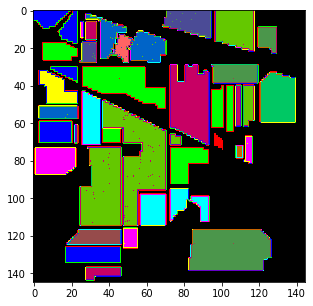

In [54]:
ground_truth = imshow(classes = y,figsize =(5,5))

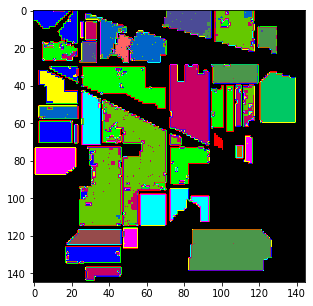

In [55]:
predict_image = imshow(classes = output.astype(int),figsize =(5,5))